# RA2CE feature: Damages analysis for hazards with return periods using the OSDamage module

    For this analysis you need hazard maps with return periods.
    The maps need to be stored in the hazard folder, have the correct naming (RP_...), be a .tif file and be in WGS84 projection

This analysis estimates the risk or estimated annual damage of the introduced hazard with given return periods. <br>

In this example, the OSdamage curves are used. 

For more information on this damage calculation method and the rationale behind it, please refer to the online documentation and "Flood risk assessment of the European road network" written by van Ginkel et. al (2021) or consult RA2CE's the online documentation or the event-based module on OSDamage. 

In this example, OSdamage vulnerability curves are used. This analysis estimates the risk or estimated annual damage of the introduced hazard with given return periods. <br>

### Let's do our imports

In [ ]:
from pathlib import Path
import geopandas as gpd
from shapely.geometry import box
import rasterio
from shapely.ops import transform
import pyproj

#RA2CE imports
from ra2ce.network.network_config_data.enums.road_type_enum import RoadTypeEnum
from ra2ce.network.network_config_data.enums.aggregate_wl_enum import AggregateWlEnum
from ra2ce.network.network_config_data.enums.source_enum import SourceEnum
from ra2ce.network.network_config_data.network_config_data import (NetworkConfigData,NetworkSection,HazardSection,)
from ra2ce.ra2ce_handler import Ra2ceHandler
from ra2ce.analysis.damages.damages import AnalysisSectionDamages
from ra2ce.analysis.analysis_config_data.enums.analysis_damages_enum import AnalysisDamagesEnum
from ra2ce.analysis.analysis_config_data.enums.event_type_enum import EventTypeEnum
from ra2ce.analysis.analysis_config_data.enums.damage_curve_enum import DamageCurveEnum
from ra2ce.analysis.analysis_config_data.analysis_config_data import AnalysisConfigData
from ra2ce.analysis.analysis_config_data.enums.risk_calculation_mode_enum import RiskCalculationModeEnum


### Set the paths

In [ ]:
root_dir = Path("data", "damages_OSdamage_return_period")
assert root_dir.exists(), "root_dir not found."

static_path = root_dir.joinpath("static")
hazard_path =static_path.joinpath("hazard")
network_path = static_path.joinpath("network")
output_path=root_dir.joinpath("output")

## Let's first find the location of the hazard map, and based on its extent, draw up a study area

In [ ]:
hazard_map = list(hazard_path.glob("*.tif"))
# Function to reproject geometry
def reproject_geometry(geom, src_crs, dst_crs):
    project = pyproj.Transformer.from_crs(src_crs, dst_crs, always_xy=True).transform
    return transform(project, geom)

# Process only the first raster file in the list
with rasterio.open(hazard_map[0]) as src:
    bbox = src.bounds
    bbox_polygon = box(bbox.left, bbox.bottom, bbox.right, bbox.top)  # Create bounding box
    src_crs = src.crs
    dst_crs = 4326

    if src_crs.to_string() != dst_crs:
        # Reproject the bounding box polygon to EPSG:4326
        bbox_polygon = reproject_geometry(bbox_polygon, src_crs, pyproj.CRS.from_epsg(dst_crs))
        print(f"Hazard Map {hazard_map[0]} is in the CRS: {src_crs}")
        print("Reprojected the polygon to EPSG:4326")

# Create a GeoDataFrame with the bounding box polygon 
gdf_polygon = gpd.GeoDataFrame(index=[0], crs='epsg:4326', geometry=[bbox_polygon])
gdf_polygon.to_file(network_path.joinpath("polygon.GeoJson"), driver='GeoJSON')

# Visualise
gdf_polygon.explore(tiles='cartoDB positron')

## Now we will set the parameters that are required to run this RA2CE analysis

    BE AWARE THAT THE FLOOD MAPS HAVE A SPECIFIC NAME FORMAT. IF YOU DO NOT USE THE CORRECT FORMAT, RA2CE WILL NOT BE ABLE TO EXECUTE THE RETURN PERIOD ANALYSIS. 
    
    The hazard files should have *RP_<return_period>* phrase in it, where *<return_period>* refers to the return period in years

There are three different methods of calculating the expected annual risk of damages as a result of the hazard. Below we schematize the different concepts briefly. There is more explanation available in the online RA2CE documentation. The expected annual damages can be calculated in three different ways. 

Note that the 'original data points' refer to the hazard's return period. These return periods stem from the hazard maps that are introduced by the user. The more return periods we have, the easier it is to 'interpolate' the curve and the more accurate the expected annual damages will be. 

1. **Default mode** in this mode, we take the area under the curve up until the highest provided return period. We do not consider risks beyond the highest provided return period, so that we do not introduce errors as a result of assumptions there. This means that there will be no damage for all events with a return period smaller than the smallest known Return Period. This method also does not account for any flood protection in place. 

2. **Cut from mode** in this mode, we can set a cut-off value (risk_calculation_year). We assume that if the return period is smaller than the cut-off value, it does not contribute to the risk. You can use such an assumption for example when there is flood protection in place, or if you want to know what the residual risk would be if you would put flood protection up to a certain return period and determine to which return period you would want to protect your infrastructure from damages. 

3. **Triangle to null mode** in this mode, we make an estimation of the total risk, including the risk for smaller return periods than the lowest return period provided in the hazard map introduced by the user. From the lowest known return period, we linearly extrapolate the damages to at which return period they would be zero. If you use this method, you can specify the RP for which damages are zero, by specifying the (risk_calculation_year) parameter in combination with the triangle to null mode. This method does not account for flood risk protection. This method is adviced if you do not have smaller return period maps, so that at least you account for some of the damages that occur in more regular floods. 



In all the modes we assume that the damage corresponding to the highest known return period is the highest damage that can occur. 

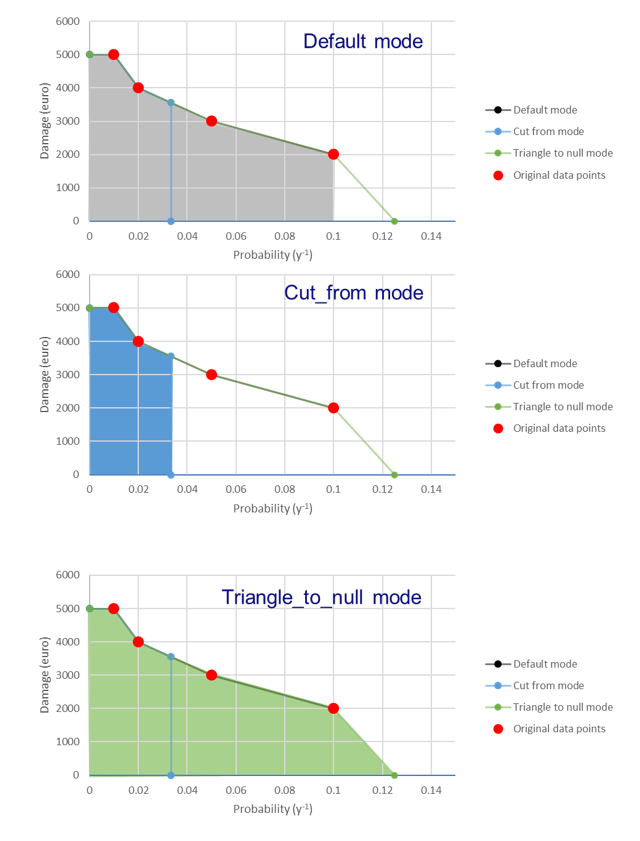

## Set up the parameters for the RA2CE analysis

In this example and for the analysis configuration, we use the OSdamage curve in combination with triangle_to_null_year risk calculation mode.

In [ ]:
polygon_study_area_path = network_path.joinpath("polygon.GeoJson")

In [ ]:
network_section = NetworkSection(
    source=SourceEnum.OSM_DOWNLOAD, #download the network from OSM 
    polygon=polygon_study_area_path, #introduce the study area's polygon that you made based on the extent of the flood maps above and specify the path of this polygon here!
    save_gpkg=True,
    road_types=[        #determine the level of detail you want to introduce to your road network. Mind that having more detail in a large area will slow down OSM download speed. 
        RoadTypeEnum.MOTORWAY,
        RoadTypeEnum.MOTORWAY_LINK,
        RoadTypeEnum.TRUNK,
        RoadTypeEnum.TRUNK_LINK,
        RoadTypeEnum.PRIMARY,
        RoadTypeEnum.PRIMARY_LINK,
        RoadTypeEnum.SECONDARY,
        RoadTypeEnum.SECONDARY_LINK,
        RoadTypeEnum.TERTIARY,
        RoadTypeEnum.TERTIARY_LINK,
    ],
)

hazard_section = HazardSection(
    hazard_map=[Path(file) for file in hazard_path.glob("*.tif")], # this finds the multiple flood maps in the hazard folder
    aggregate_wl = AggregateWlEnum.MEAN, #mean water level is used for damage analysis
    hazard_crs = "EPSG:4326", #Make sure your hazard map is in 4326
)

network_config_data = NetworkConfigData(
    root_path=root_dir,
    static_path=static_path,
    output_path=output_path,
    network=network_section,
    hazard=hazard_section
)
network_config_data.network.save_gpkg = True


Set the analysis parameters. Read the comments for explanation on each parameter or analyse AnalysisSectionDamage in the RA2CE base code

In this notebook we have set the risk calculation mode as Triangle to null mode. You can set a different mode for the analysis below in the risk_calculation_mode segment

In [ ]:
#specify the parameters for the damage analysis 
damages_analysis = [AnalysisSectionDamages( 
    
  name = 'RP_damages_OSD', #specify the name for your analysis

  analysis= AnalysisDamagesEnum.DAMAGES, #If you do damage analysis you should choose damages here

  event_type = EventTypeEnum.RETURN_PERIOD, #We can specify return period based and event based here. If you have multiple flood maps with return periods, put return period. 

  damage_curve = DamageCurveEnum.OSD, #Set the damage curve you would like to use. HZ and OsDamage are built-in damage curves. For manual damage curves you need to add more data yourself. See the manual damage curve examples. 

  risk_calculation_mode = RiskCalculationModeEnum.TRIANGLE_TO_NULL_YEAR, # Other options: #RiskCalculationModeEnum.CUT_FROM_YEAR, #RiskCalculationModeEnum.DEFAULT, 

  risk_calculation_year = 5,#For Triangle_to_null_year: this parameters is the year at which the damages are assumed to be zero. You can only put a number below your lowest RP.
                            #For cut_from_mode: this parameter is the year below which we assume no damage (usually because of protection or adaptation measures). For this mode you need to specify a number above your lowest provided RP. 
                            #For the default mode this parameter is not used
  
  #save your outputs as both csv and gpkg in the output folder                          
  save_csv=True,
  save_gpkg=True
  )]

analysis_config_data = AnalysisConfigData(
    analyses= damages_analysis,
    root_path= root_dir,
    output_path= output_path,
    )


##### Run RA2CE with the configuration parameters

In [ ]:
Ra2ceHandler.run_with_config_data(
    network_config_data, analysis_config_data)

# Now we will inspect and visualize some of the results

We get results on two spatial levels: 
- segmented results : these are the damages result on the specified segment lenght (e.g. 100)
- link-based results : these are the damages results aggregated to the link-level

These are outputted to your local machine as geospatial data packages (.gpkg) which we can visualize in both python and a GIS

Let's find the results that RA2CE outputted to your output folder

In [ ]:
analysis_output_path = root_dir.joinpath("output","damages")
damage_gdf = gpd.read_file(analysis_output_path.joinpath('RP_damages_OSD_segmented.gpkg'))
damage_gdf.head() #show the origins

## Results Explanation

We see that there are a couple of damage related columns: dam_Cx_EV1_representative and _quartiles. The Cx number refers to the damage curve number and the 'RP' refers to the return period of the floodmap. <br>
<br>Since we only have flood maps for three return periods, we have results for RP10, RP100 and RP1000.<br> 
<br>This principle stems from the paper ("Flood risk assessment of the European road network" written by van Ginkel et. al (2021)) as explained above.<br> 
<br>Below, you can find the damage curves. There are different damage curves for different road types. Dependig on the low / high flow of the flood, the damages are also different. We adivse to use the damage curve(s) that are most applicable to your situation. For example, if you are interested in sophisticated roads with a high flow situation, you can add the columns for damage curves 2 and 6 to make up your whole road network of motorways and other roads. See the picture above to determine which curves you find most interesting to inspect<br>

The risk can be found in columns labeled risk_Cx where the number refers to the damage curve number as visualized below.

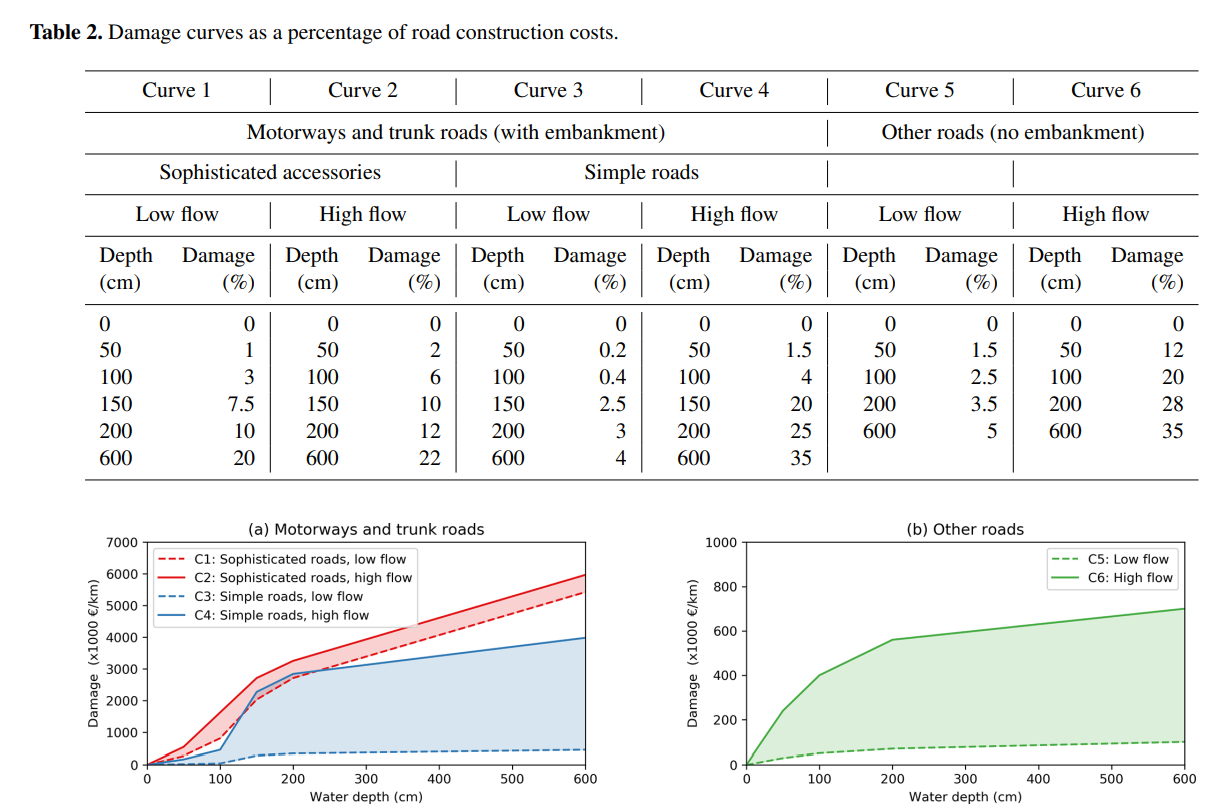

Lets visualize the damage for each flood scenario for road types

In [ ]:
return_period = 100 #Add your return period here
damage_curve = 5 #Add the damage curve number for the corresponding roads

return_period_damage = f'dam_C{damage_curve}_RP{return_period}_representative'
damage_gdf.explore(column = return_period_damage, tiles="CartoDB positron")

Show the flood risk for the included flood maps and return periods.

In [ ]:

risk = 5 #Add the damage curve number for the corresponding roads

risk_col = f'risk_C{risk}'
damage_gdf.explore(column = risk_col, tiles="CartoDB positron")

## Let's explore a scenario with simple roads and other roads with a high flow flood

In [ ]:
#Here we use the link based result
damage_gdf = gpd.read_file(analysis_output_path.joinpath('RP_damages_OSD_link_based.gpkg'))

### Let's explore the how floods in different return periods impact the selected road network


In [ ]:
damage_gdf_combine = damage_gdf.copy()
damage_gdf_combine['high_flow_results_soph_RP10'] = damage_gdf_combine[f'dam_C4_RP100_representative'].fillna(0) + damage_gdf_combine['dam_C6_RP100_representative'].fillna(0)
damage_gdf_combine['high_flow_results_soph_RP1000'] = damage_gdf_combine[f'dam_C4_RP1000_representative'].fillna(0) + damage_gdf_combine['dam_C6_RP1000_representative'].fillna(0)

Show damages for selected return period

In [ ]:
return_period = 1000 #select the return period

return_period_col = f'high_flow_results_soph_RP{return_period}'
damage_gdf_combine.explore(column = return_period_col, tiles="CartoDB positron")

Show the flood risk for the selected road network

In [ ]:

damage_gdf_combine['high_flow_results_risk'] = damage_gdf_combine['risk_C4'].fillna(0) + damage_gdf_combine['risk_C6'].fillna(0)
damage_gdf_combine.explore(column = 'high_flow_results_risk', tiles="CartoDB positron")

What is the total risk according to this method?

In [ ]:
total_risk = damage_gdf_combine["high_flow_results_risk"].sum()
valuta = "Euro"
print(f"Total damages from this hazard on the analyzed road network according to the specified method is: {round(total_risk, 0)} {valuta}")